# Machine Translation with RNN and Transformer

In [1]:
import tensorflow as tf 
from tensorflow import keras


2024-11-16 12:36:27.792488: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:485] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-16 12:36:27.856913: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:8454] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-16 12:36:27.875769: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1452] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-16 12:36:28.004191: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-11-16 12:36:29.124922: W tensorflow/compiler/tf2

In [2]:
import numpy as np

In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    for gpu in gpus:
        tf.config.experimental.set_memory_growth(gpu, True)

I0000 00:00:1731760592.403314  125746 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731760592.564108  125746 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731760592.564156  125746 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.


## 1. Dataset Preprocessing

### 1.1. Load dataset

In [4]:
text_file = 'spa-eng/spa.txt'

with open(text_file) as f:
    lines = f.read().split("\n")[:-1]


lines[:10]

['Go.\tVe.',
 'Go.\tVete.',
 'Go.\tVaya.',
 'Go.\tVáyase.',
 'Hi.\tHola.',
 'Run!\t¡Corre!',
 'Run.\tCorred.',
 'Who?\t¿Quién?',
 'Fire!\t¡Fuego!',
 'Fire!\t¡Incendio!']

In [4]:
len(lines)

118964

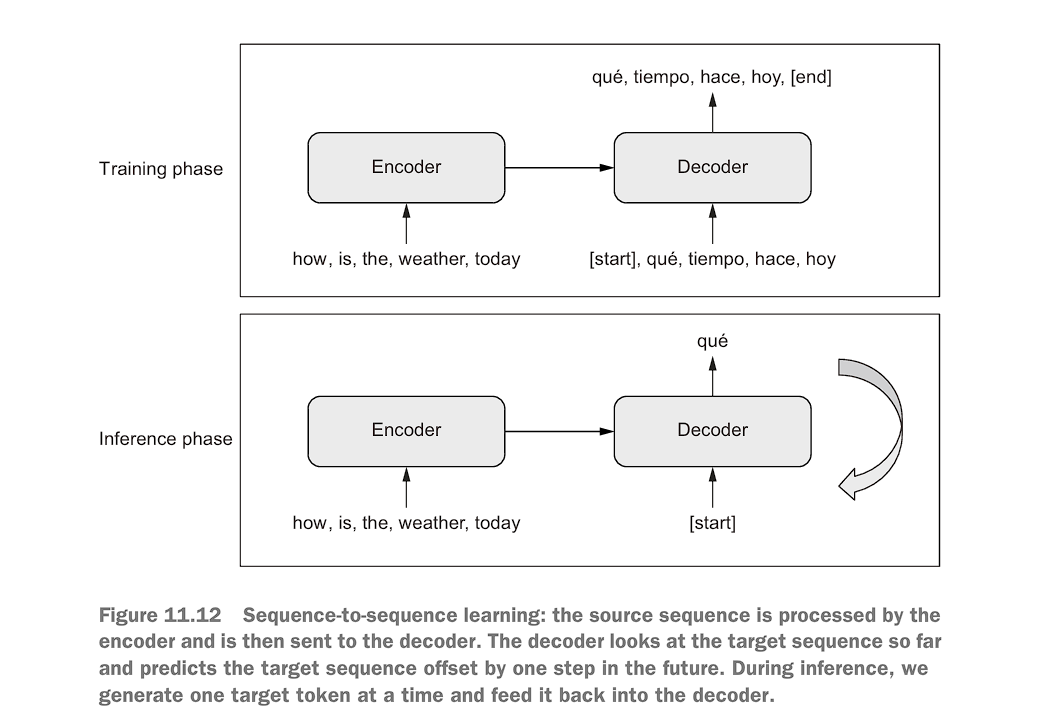

### 1.2. Make English-spanish pairs

In [5]:
text_pairs = []

for line in lines:
    english, spanish = line.split("\t")
    '''
    We prepend "[start]" and append "[end]" to the Spanish
    sentence, to match the template from figure 11.12. 
    '''
    spanish = "[start]" + spanish + "[end]"
    text_pairs.append((english, spanish))


In [17]:
text_pairs[50:55]

[("Tom could have paid for Mary's ticket if he'd known she didn't have enough money.",
  '[start]Tom podía haber pagado la entrada de María si hubiera sabido que no tenía suficiente dinero.[end]'),
 ('If you hurry up, you will be in time.',
  '[start]Si te das prisa llegarás a tiempo.[end]'),
 ('Nothing is free.', '[start]Nada es gratis.[end]'),
 ("Tom doesn't like to wear a watch.",
  '[start]A Tom no le gusta ponerse reloj.[end]'),
 ("I've never thought about giving up.",
  '[start]Nunca he pensado en abandonar.[end]')]

In [6]:
import random
print(random.choice(text_pairs))

('He had few friends and little money.', '[start]Él tenía pocos amigos y poco dinero.[end]')


### 1.3. Split into training, validation and test sets

In [7]:
random.shuffle(text_pairs)
num_val_samples = int(0.15 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples

train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples:]

In [9]:
len(train_pairs), len(val_pairs)

(83276, 17844)

## 2. Vectorizing the English and Spanish text pairs

* For simplicity, we’ll get rid of all punctuation
* Preserve the "[start]" and "[end]" tokens that we’ve inserted

In [8]:
import string 
import re 

In [9]:
strip_chars = string.punctuation + "¿"
strip_chars = strip_chars.replace("[", "")
strip_chars = strip_chars.replace("]", "")

In [10]:
strip_chars

'!"#$%&\'()*+,-./:;<=>?@\\^_`{|}~¿'

Define a TextVectorization to preprocess English and Spanish text separately

In [10]:
l = re.escape(strip_chars)
l

'!"\\#\\$%\\&\'\\(\\)\\*\\+,\\-\\./:;<=>\\?@\\\\\\^_`\\{\\|\\}\\~¿'

In [11]:
def custom_standardization(input_string):
    lowercase = tf.strings.lower(input_string)

    return tf.strings.regex_replace(lowercase, f"[{re.escape(strip_chars)}]", "")

To keep things simple, we’ll only look at the top 15,000 words in each language, and we’ll restrict sentences to 20 words.

In [12]:
vocab_size = 15000
sequence_length = 20

# English layer
source_vectorization = keras.layers.TextVectorization(
    max_tokens = vocab_size,
    output_mode = "int",
    output_sequence_length = sequence_length
)
''' English layer standardization is default 
since it doesn't need to make special exception for [start] or [end]'''
# Spanish layer
target_vectorization = keras.layers.TextVectorization(
    max_tokens = vocab_size,
    output_mode = "int", 
    output_sequence_length = sequence_length + 1,
    standardize = custom_standardization
)


I0000 00:00:1731760613.450904  125746 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731760613.450973  125746 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731760613.451003  125746 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731760614.169067  125746 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
I0000 00:00:1731760614.169163  125746 cuda_executor.cc:1001] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-11-16

### Why +1 ?
Suppose the target sentence is ¿Cómo estás?.

* Target Input (Decoder input) (offset by one): start ¿Cómo estás?
* Target Output (Decoder output) (shifted): ¿Cómo estás? end

In [13]:
train_english_text = [pair[0] for pair in train_pairs]
train_spanish_text = [pair[1] for pair in train_pairs]

source_vectorization.adapt(train_english_text)
target_vectorization.adapt(train_spanish_text)

## 3. Build the tf.data pipeline

The pipeline should return a tuple (inputs, target) where inputs is a dict with two keys:

* “encoder_inputs” (the English sentence) 
* “decoder_inputs” (the Spanish sentence), 

and target is the Spanish sentence offset by one step ahead.

In [14]:
# "<start> ¿Cómo estás? <end>"
#  Will be tokenized to vector say:
vec = [1, 42, 85, 2]

dec_inp = vec[:-1]
dec_out = vec[1:]

print(dec_inp, dec_out)

[1, 42, 85] [42, 85, 2]


In [15]:
batch_size = 32

def format_dataset(eng, spa):
    eng = source_vectorization(eng)
    spa = target_vectorization(spa)

    return {
        "english": eng,
        "spanish": spa[:, :-1],
    }, spa[:, 1:]

''' 
For decoder inputs, last token <end> is excluded and to make them
same length, remove <start> token from target

The first : is because of batch dimension
'''


def make_dataset(pairs):
    # Unzip the tuples into separate tuples (see example in below cell)
    eng_texts, spa_texts = zip(*pairs)

    # This returns tuples not list but from_tensor_slices 
    # expects lists or np arrays (i.e. mutable and iterable structures)
    eng_texts = list(eng_texts)
    spa_texts = list(spa_texts)

    dataset = tf.data.Dataset.from_tensor_slices((eng_texts, spa_texts))
    dataset = dataset.batch(batch_size)
    dataset = dataset.map(format_dataset, num_parallel_calls=4)

    return dataset.shuffle(2048).prefetch(16).cache()

`prefetch()` allows the data pipeline to prepare (or "prefetch") batches of data in the background while the model is training.

`cache()` stores the dataset in memory (or on disk, if specified) after the first pass through it.

In [16]:
pairs = [("hello", "hola"), ("world", "mundo")]
eng_texts, spa_texts = zip(*pairs) 
eng_texts, spa_texts

(('hello', 'world'), ('hola', 'mundo'))

In [17]:
train_ds = make_dataset(train_pairs)
val_ds = make_dataset(val_pairs)

In [18]:
for inputs, targets in train_ds.take(1):
    print("Inputs:", inputs)  # Should be a dictionary with keys 'english' and 'spanish'
    print("Targets:", targets)  # Should be the target tensor

Inputs: {'english': <tf.Tensor: shape=(32, 20), dtype=int64, numpy=
array([[   3,   17,  190,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   3,   22,   38,   24,   33,   71,    4,   15,  303,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  27,   17,   69, 7678,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   6,  201,  318,    4,  148,   39,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [ 102,  344,   11,   28,  328, 3648,  373,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   6,  241,  174,   56,  250,  330,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [  80,   61,  178,   57,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0

2024-11-16 12:37:05.643113: W tensorflow/core/kernels/data/cache_dataset_ops.cc:913] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.
2024-11-16 12:37:05.645952: I tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


## 4. Seq-to-Seq with RNNs 

### 4.1. Building the architecture

The simplest, naive way to use RNNs to turn a sequence into another sequence is to keep the output of the RNN at each time step.

```python
inputs = keras.Input(shape=(sequence_length,), dtype="int64")
x = layers.Embedding(input_dim=vocab_size, output_dim=128)(inputs)
x = layers.LSTM(32, return_sequences=True)(x)
outputs = layers.Dense(vocab_size, activation="softmax")(x)
model = keras.Model(inputs, outputs)

*BUT* this approach is not suitable because:
1. The input sequence is processed step by step in a time-dependent manner, meaning each step depends on the previous one. So, it is SLOW 

2. No attention mechanism so no alignment of words i.e. correspondence between one language and another is not learnt properly.

3. While the LSTM can capture dependencies within the sequence, it may struggle with long-range dependencies between words in the source and target sentences.

If you’re a human translator, you’d start by reading the entire source sentence before starting to translate it. This is especially important if you’re dealing with languages that have wildly different word ordering, like English and Japanese. And that’s exactly what standard sequence-to-sequence models do.

**So, we use Seq2Seq architecture** 
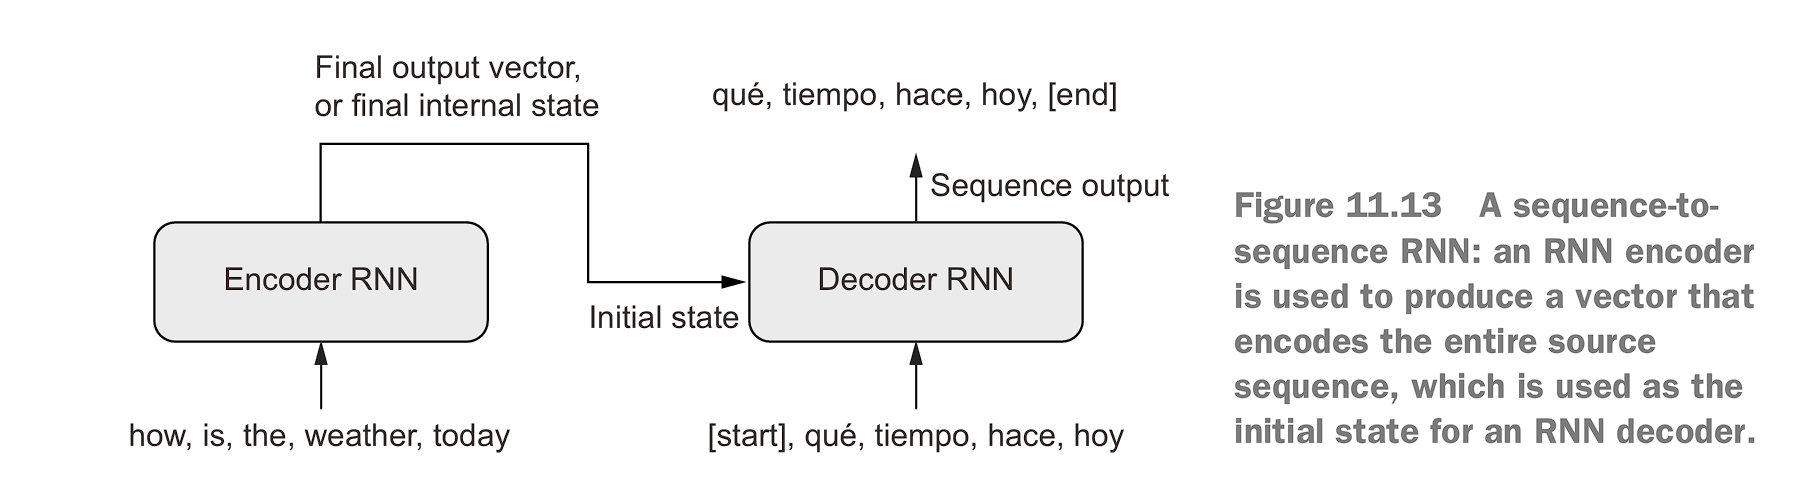

We are not including attention mechanism in this architecture

In [52]:
embed_dim = 256
latent_dim = 1024

# Encoder GRU
source = keras.Input(shape = (None, ), dtype = "int32", name = "english")
# The None dimension allows for variable-length sequences.
x = keras.layers.Embedding(vocab_size, embed_dim, mask_zero=True)(source)
# Masking is enabled to ignore padding (prevent model from trying to learn through padded values)
encoded_source = keras.layers.Bidirectional(
    keras.layers.GRU(latent_dim), merge_mode = "sum")(x)


# Decoder GRU
past_target = keras.Input(shape=(None, ), dtype = "int32", name = "spanish")
x = keras.layers.Embedding(vocab_size, embed_dim, mask_zero = True)(past_target)
# the decoder processes input tokens one step at a time and generates the output sequence incrementally
decoder_gru = keras.layers.GRU(latent_dim, return_sequences=True)
x = decoder_gru(x, initial_state = encoded_source)
x = keras.layers.Dropout(0.5)(x)
target_next_step = keras.layers.Dense(vocab_size, activation = "softmax")(x)

seq2seq_rnn = keras.Model(
    inputs = {"english":source, "spanish":past_target},
    outputs = target_next_step)

1. with return_sequences=True:
```python 
    inp : [<START>, token_1, token_2]

    # GRU produces hidden states for all time steps:
    Hidden states : [h_t1, h_t2, h_t3]

    # The Dense layer applies softmax to each hidden state to produce a token prediction for each time step:
    Output: [predicted_token_1, predicted_token_2, predicted_token_3]
```

2. return_sequences = False
```python
    # GRU produces only the final hidden state
    Hidden state: [h_final]

    # Only one token prediction is generated
    Output: [predicted_token_final]


In [53]:
seq2seq_rnn.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ english             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spanish             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_4         │ (None, None, 256) │  3,840,000 │ english[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal_4         │ (None, None)      │          0 │ english[0][0]     │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_5         │ (None, None, 256) │  3,840,000 │ spanish[0][0]     │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional_2     │ (None, 1024)      │  7,876,608 │ embedding_4[0][0… │
│ (Bidirectional)     │                   │            │ not_equal_4[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ gru_5 (GRU)         │ (None, None,      │  3,938,304 │ embedding_5[0][0… │
│                     │ 1024)             │            │ bidirectional_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, None,      │          0 │ gru_5[0][0]       │
│                     │ 1024)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, None,      │ 15,375,000 │ dropout_2[0][0]   │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 34,869,912 (133.02 MB)

 Trainable params: 34,869,912 (133.02 MB)

 Non-trainable params: 0 (0.00 B)

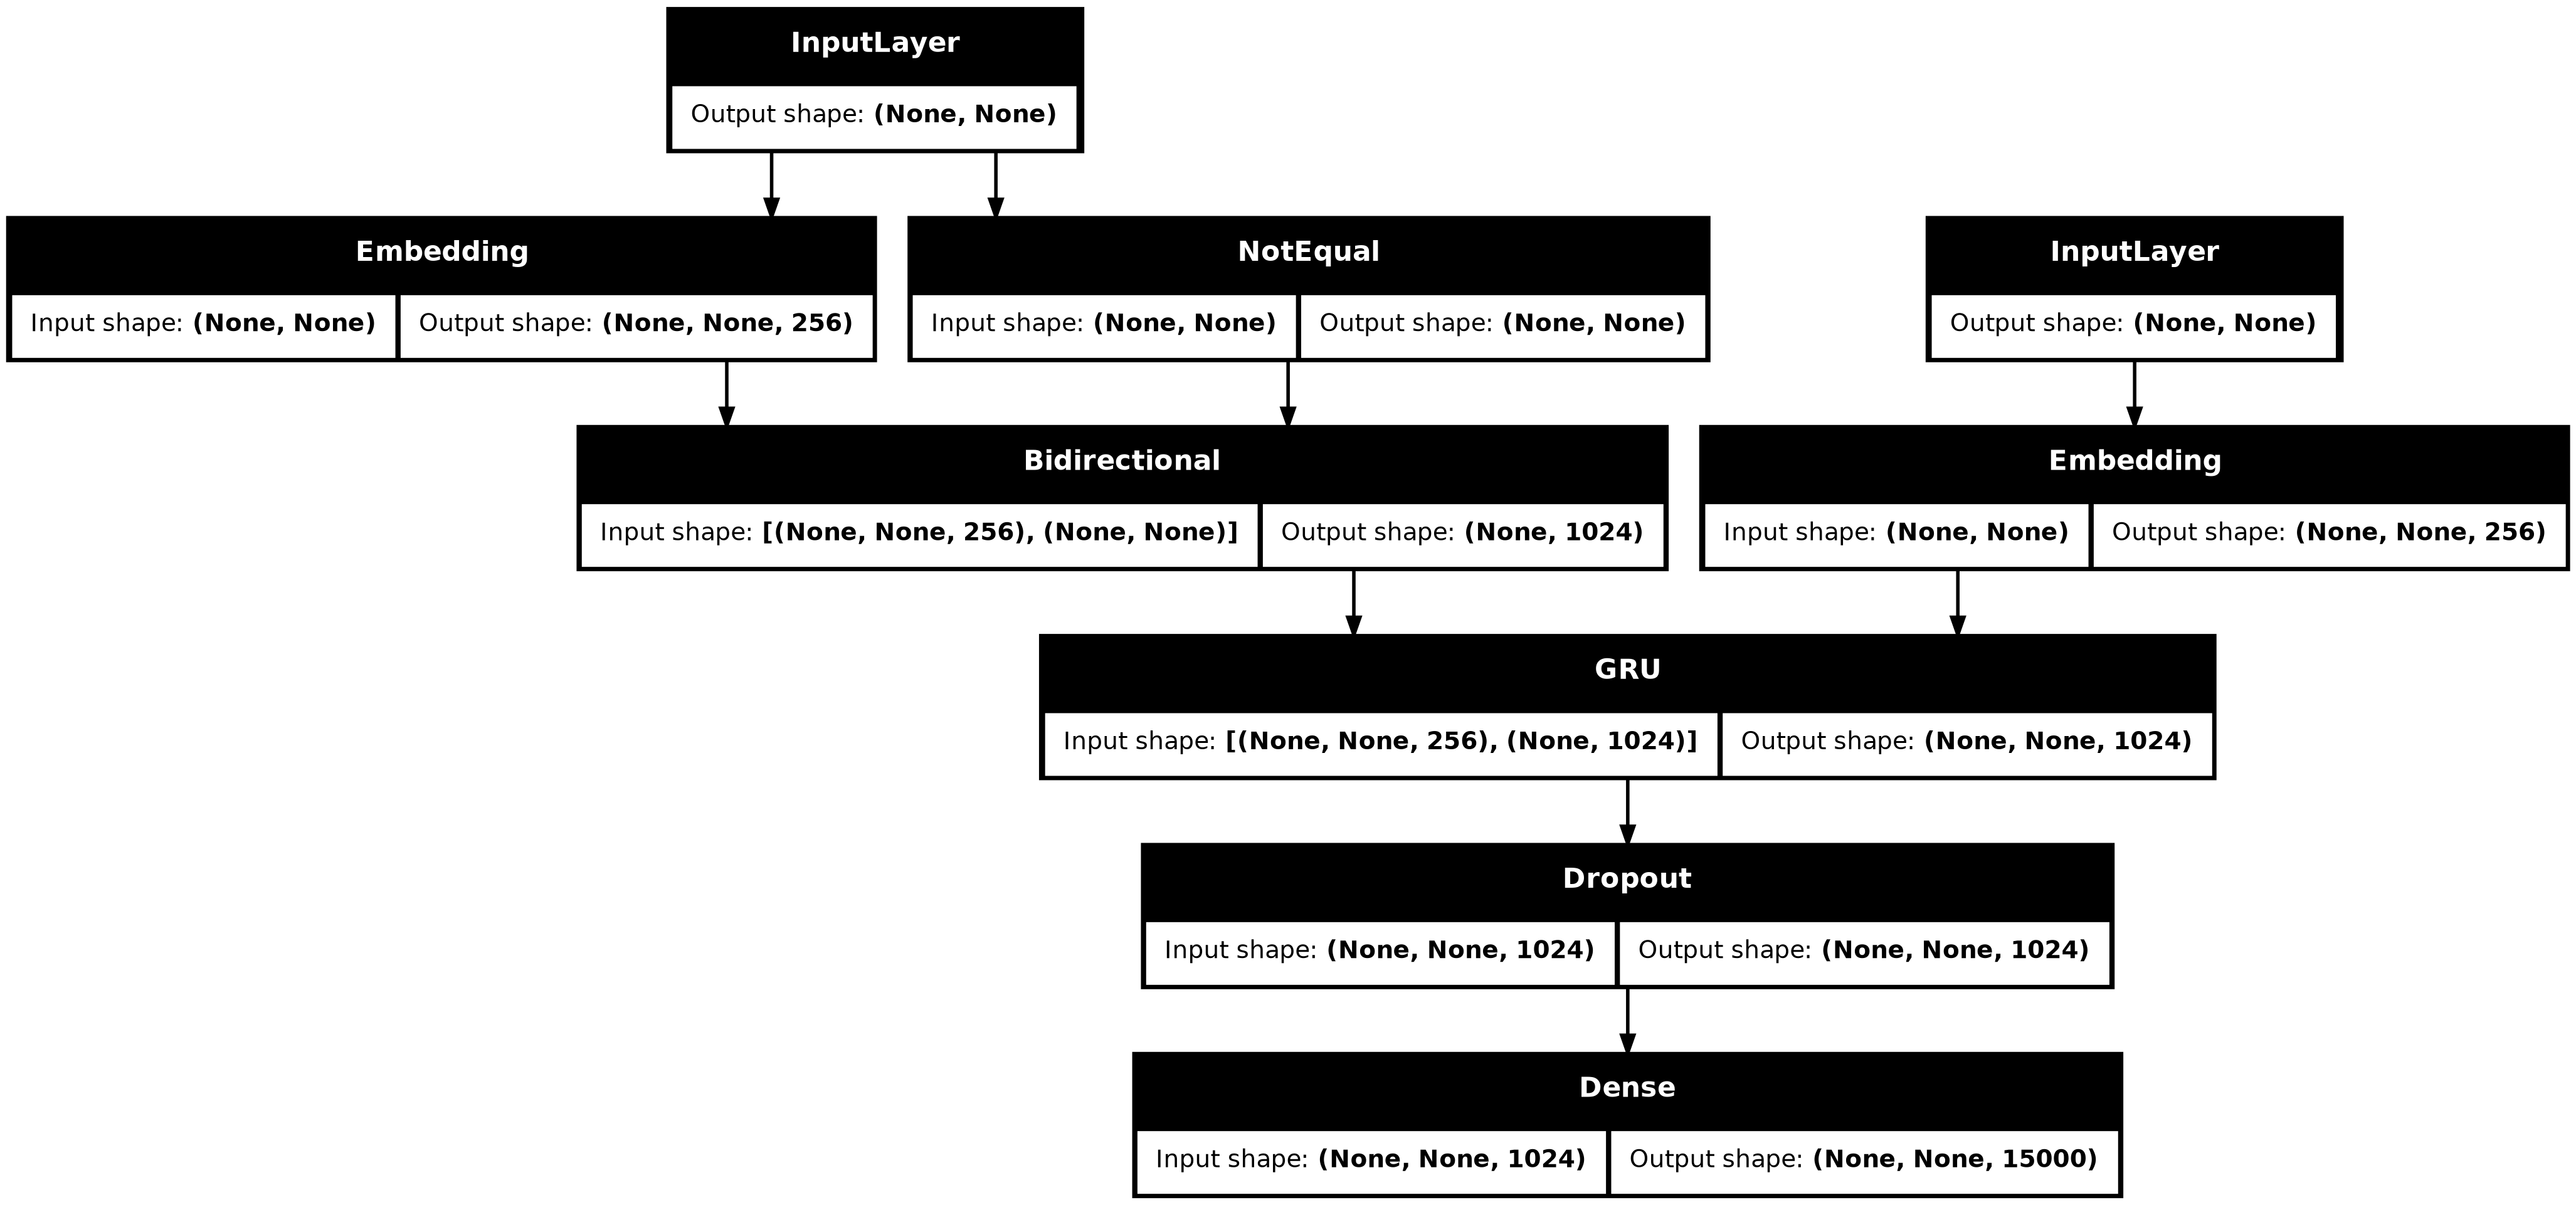

In [54]:
keras.utils.plot_model(seq2seq_rnn, to_file = "GRU encoder_decoder.png", show_shapes = True)

### 4.2. Training the model

In [56]:
seq2seq_rnn.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

seq2seq_rnn.fit(train_ds, epochs=10, validation_data=val_ds)

Epoch 1/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 174s 66ms/step - accuracy: 0.7613 - loss: 5.6578 - val_accuracy: 0.8057 - val_loss: 4.3110
Epoch 2/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 173s 66ms/step - accuracy: 0.7917 - loss: 4.3901 - val_accuracy: 0.8283 - val_loss: 3.6859
Epoch 3/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 173s 67ms/step - accuracy: 0.7804 - loss: 3.8061 - val_accuracy: 0.8321 - val_loss: 3.3339
Epoch 4/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 173s 66ms/step - accuracy: 0.7821 - loss: 3.4207 - val_accuracy: 0.8420 - val_loss: 3.1123
Epoch 5/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 174s 67ms/step - accuracy: 0.7852 - loss: 3.1446 - val_accuracy: 0.8376 - val_loss: 2.9777
Epoch 6/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 173s 67ms/step - accuracy: 0.7851 - loss: 2.9313 - val_accuracy: 0.8221 - val_loss: 2.8805
Epoch 7/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 173s 67ms/step - accuracy: 0.7705 - loss: 2.7738 - val_accuracy: 0.8457 - val_loss: 2.8066
Epoch 8/10
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 174s 67ms/step - accuracy: 

In [51]:
for input_layer in seq2seq_rnn.inputs:
    print(f"Name: {input_layer.name}, Shape: {input_layer.shape}, Dtype: {input_layer.dtype}")

Name: english, Shape: (None, None), Dtype: int32
Name: spanish, Shape: (None, None), Dtype: int32


In [57]:
seq2seq_rnn.save("GRU_encoder_decoder.keras")

### 4.4. Inference using RNN model

We’ll start from the seed token, "[start]",and feed it into the decoder model, together with the encoded English source sentence. We’ll retrieve a next-token prediction, and we’ll re-inject it into the decoder repeatedly, sampling one new target token at each iteration, until we get to "[end]" or reach the maximum sentence length

In [58]:
model = keras.models.load_model("GRU_encoder_decoder.keras")

In [63]:
# Prepare a dict to convert token index predictions to string tokens.

spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"  # Seed token

    for i in range(max_decoded_sentence_length):
        # Tokenize the current decoded sentence
        tokenized_target_sentence = target_vectorization([decoded_sentence])

        # Predict next token
        next_token_predictions = model.predict(
            {"english":tokenized_input_sentence, "spanish":tokenized_target_sentence}, \
            verbose = 0
        )

        # selects the index of the token with the highest probability 
        # from the prediction.
        # shape = (next_batch_size, max_decoded_sentence_length, target_vocab_size)

        # 0: Refers to the first (and only) batch item. Since the batch size is 1, this is always 0
        # i: Refers to the position of the token in the decoded sequence 
        # :: Refers to all values for the target vocabulary at this specific token position. 
        # This means all possible token predictions (i.e., the probability distribution over the entire vocabulary) for the i-th position
        
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])

        # Retrieve the token
        sampled_token = spa_index_lookup[sampled_token_index]  

        # Update the decoded sentence
        decoded_sentence += " " + sampled_token

        # Termination condition   
        if sampled_token == "[end]":     
            break

    return decoded_sentence

In [64]:
test_eng_texts = [pair[0] for pair in test_pairs] 
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
I was called on in English class.
[start] en la oficina de inglés[end]               
-
When does it arrive?
[start]                    
-
Haven't we met before?
[start] de vez en cuando[end]                
-
According to the newspaper, it's going to rain today.
[start] el [UNK] para ir a llover[end]  hoy[end]  hoy[end]        de de de
-
He is no longer a child.
[start] no es una niña[end]        a        
-
She quit her job last month.
[start] su trabajo el mes pasado[end]         del del del    
-
Please take one.
[start] por favor[end]     por   por por por        
-
I lost my way in the forest.
[start] mi [UNK] en el bosque[end]               
-
I don't understand and I'm not used to not understanding. Please explain it once more.
[start] no y no [UNK] la [UNK]  en            
-
He plays tennis every day.
[start] al tenis todos los días[end]               
-
What do you think I've been doing?
[start] que me he estado haciendo[end]               
-
I love you both.
[start] a los 

#### Improvements that can be made:
1. Use of LSTM instead of GRU
2. Using a deep stack of recurrent layers.
3. Usage of BLEU metric

## 5. Seq2Seq with Transformers

Neural attention enables Transformer models to successfully process sequences that are considerably longer and more complex than those RNNs can handle.

Just like the RNN decoder,the Transformer decoder reads tokens 0…N in the target sequence and tries to predict token N+1. Crucially, while doing this, it uses neural attention to identify which tokens in the encoded source sentence are most closely related to the target token it’s currently trying to predict—perhaps not unlike what a human translator would do. 

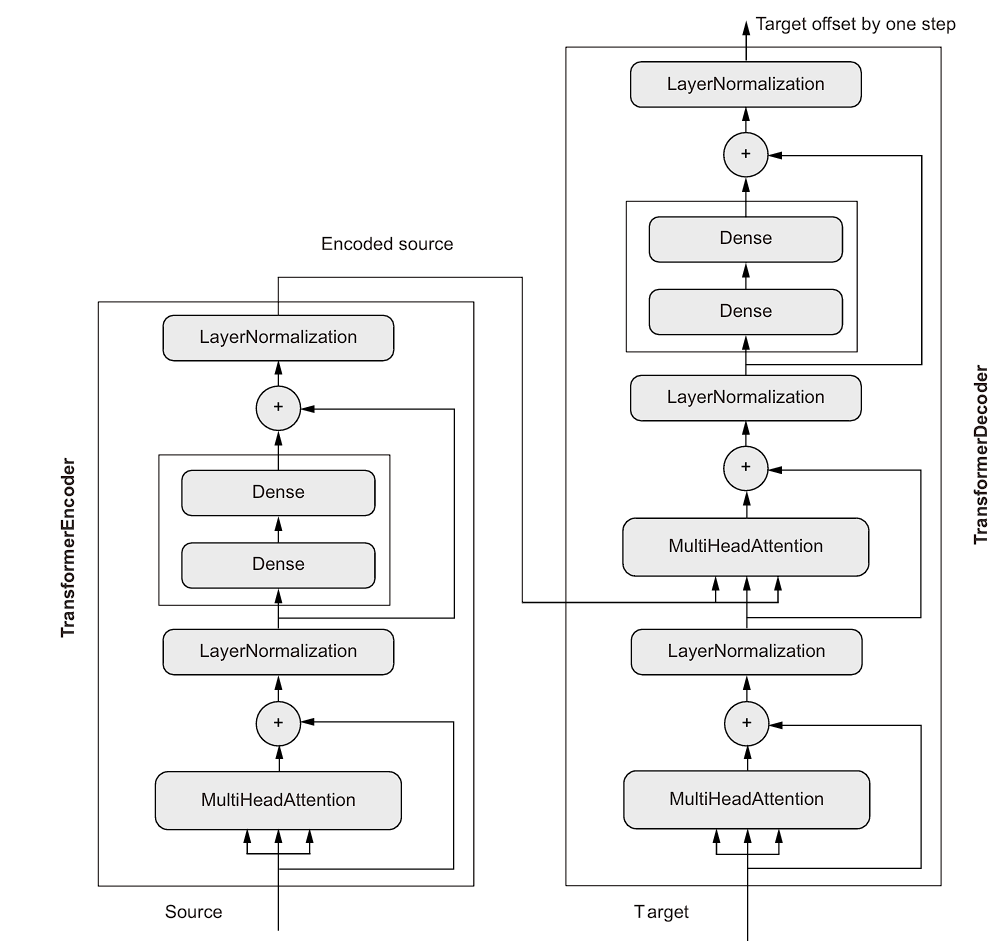

In [19]:
from keras import layers

In [56]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)

        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads 

        self.attention = layers.MultiHeadAttention(
            num_heads = num_heads,
            key_dim = embed_dim
        )

        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation = "relu"),
            layers.Dense(embed_dim)
        ])

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
    '''
    The attention mechanism works with tensors of shape:
    (batch_size, num_heads, query_length, key_length) for attention scores.

    A mask might originally have shape (batch_size, key_length).

    Broadcasting allows the mask to be reshaped (e.g., (batch_size, 1, key_length)) 
    and then expanded to (batch_size, num_heads, query_length, key_length), 
    aligning it with the attention scores.
    '''
    # Forward pass
    def call(self, inputs, mask=None):
        if mask is not None:
            # print(f"Original mask shape: {mask.shape}")
            mask = mask[:, tf.newaxis, :]
        
        attention_output = self.attention(
            query = inputs, 
            value = inputs,
            key = inputs, 
            attention_mask= mask)
        
        proj_inp = self.layernorm_1(inputs + attention_output)

        proj_out = self.dense_proj(proj_inp)

        return self.layernorm_2(proj_inp + proj_out)
    
    
    # Implement serializationso we can save the model.

    def get_config(self):   
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
            })
        return config



In [57]:
class TransformerDecoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads

        self.attention1 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim = embed_dim 
        )

        self.attention2 = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim = embed_dim 
        )

        self.dense_proj = keras.Sequential([
            layers.Dense(dense_dim, activation = "relu"),
            layers.Dense(embed_dim)
        ])

        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.layernorm_3 = layers.LayerNormalization()

    
    def get_config(self):
        config = super().get_config()
        config.update({
        "embed_dim": self.embed_dim,
        "num_heads": self.num_heads,
        "dense_dim": self.dense_dim,
        })
        return config
    
    # '''
    # Transformers are inherently parallelizable, meaning they can compute 
    # attention for all positions in a sequence at once. However, during text
    # generation, the model should not "cheat" by looking at future words when
    # predicting the next word. 

    # Causal masking ensures that at any position 𝑡, the model only attends to tokens up to 𝑡 and not beyond it.
    # '''

    def get_causal_attention_mask(self, inputs):
        # '''
        # returns mask of shape: (batch_size,sequence_length,sequence_length) 
        # '''
        # The shape of the input tensor is determined dynamically
        input_shape = tf.shape(inputs)
        batch_size, sequence_length = input_shape[0], input_shape[1]

        # Generate a range tensor
        i = tf.range(sequence_length)[:, tf.newaxis] # column vector of sequence positions

        j = tf.range(sequence_length) # row vector of sequence positions

        # Create a mask which is a lower triangular matrix 
        mask = tf.cast(i >= j, dtype = "int32")

        # Reshape mask into shape (1, sequence_length, sequence_length) to represent a single sequence.
        # mask = tf.reshape(mask, (1, sequence_length, sequence_length))
        mask = tf.reshape(mask, (1, input_shape[1], input_shape[1]))

        # mult is a tensor specifying the number of repetitions for each dimension of the causal mask when using tf.tile.
        mult = tf.concat(
            [tf.expand_dims(batch_size, -1),
             tf.constant([1,1], dtype = tf.int32)], axis = 0
        )

        return tf.tile(mask, mult)
    

    def call(self, inputs, encoder_outputs, mask=None):
        causal_mask = self.get_causal_attention_mask(inputs)
        if mask is not None:
            padding_mask = tf.cast(
                mask[:, tf.newaxis, :], dtype="int32")
            padding_mask = tf.minimum(padding_mask, causal_mask)
        else:
            padding_mask = causal_mask
        attention_output_1 = self.attention1(
            query=inputs,
            value=inputs,
            key=inputs,
            attention_mask=causal_mask)
        attention_output_1 = self.layernorm_1(inputs + attention_output_1)
        attention_output_2 = self.attention2(
            query=attention_output_1,
            value=encoder_outputs,
            key=encoder_outputs,
            attention_mask=padding_mask,
        )
        attention_output_2 = self.layernorm_2(
            attention_output_1 + attention_output_2)
        proj_output = self.dense_proj(attention_output_2)
        return self.layernorm_3(attention_output_2 + proj_output)
    

In [45]:
l = tf.range(5)[:, tf.newaxis]
l

<tf.Tensor: shape=(5, 1), dtype=int32, numpy=
array([[0],
       [1],
       [2],
       [3],
       [4]], dtype=int32)>

In [42]:
from tensorflow.keras import backend as K

In [58]:
class PositionalEmbedding(layers.Layer):
    def __init__(self, sequence_length, input_dim, output_dim, **kwargs):
        super().__init__(**kwargs)
        self.token_embeddings = layers.Embedding(
            input_dim=input_dim, output_dim=output_dim,
            mask_zero=True)
        self.position_embeddings = layers.Embedding(
            input_dim=sequence_length, output_dim=output_dim)
        self.sequence_length = sequence_length
        self.input_dim = input_dim
        self.output_dim = output_dim

    def call(self, inputs):
        length = tf.shape(inputs)[-1]
        positions = tf.range(start=0, limit=length, delta=1)
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings(positions)
        return embedded_tokens + embedded_positions

    # def compute_mask(self, inputs, mask=None):
    #     # return keras.layers.Lambda(lambda x: tf.not_equal(x, 0))(inputs)
    #     # return tf.math.not_equal(inputs, 0)
    #     return self.token_embeddings.compute_mask(inputs, mask)

    def get_config(self):
        config = super(PositionalEmbedding, self).get_config()
        config.update({
            "output_dim": self.output_dim,
            "sequence_length": self.sequence_length,
            "input_dim": self.input_dim,
        })
        return config

In [31]:
batch_size = 3
sequence_length = 4

i = tf.range(sequence_length)[:, tf.newaxis] # column vector of sequence positions

j = tf.range(sequence_length) # row vector of sequence positions

# Create a mask which is a lower triangular matrix 
mask = tf.cast(i >= j, dtype = "int32")
print("Before reshapee:", mask)
# Reshape mask into shape (1, sequence_length, sequence_length) to represent a single sequence.
mask = tf.reshape(mask, (1, sequence_length, sequence_length))

print("After reshape:", mask)
mult = tf.concat(
    [tf.expand_dims(batch_size, -1),
        tf.constant([1,1], dtype = tf.int32)], axis =0
)

print("Mult:", mult)

mult1 = tf.concat(
    [tf.expand_dims(tf.expand_dims(batch_size, -1), -1),
     tf.constant([[1]], dtype = tf.int32)], axis = 1
)
print("Mult1:", mult1)

Before reshapee: tf.Tensor(
[[1 0 0 0]
 [1 1 0 0]
 [1 1 1 0]
 [1 1 1 1]], shape=(4, 4), dtype=int32)
After reshape: tf.Tensor(
[[[1 0 0 0]
  [1 1 0 0]
  [1 1 1 0]
  [1 1 1 1]]], shape=(1, 4, 4), dtype=int32)
Mult: tf.Tensor([3 1 1], shape=(3,), dtype=int32)
Mult1: tf.Tensor([[3 1]], shape=(1, 2), dtype=int32)


To give the model access to word order information, we’re going to add the word’s position in the sentence to each word embedding. Our input word embeddings will have two components: the usual word  vector, which represents the word independently of any specific context, and a position vector, which represents the position of the word in the current sentence.

We use a technique called `positional embedding` which is different to the one used in `Attention is all you need` paper (cosine functions)



In [59]:
embed_dim = 256 
dense_dim = 2048 
num_heads = 6

encoder_inputs = keras.Input(shape=(None,), dtype="int32", name="english")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(encoder_inputs)
encoder_outputs = TransformerEncoder(embed_dim, dense_dim, num_heads)(x)

decoder_inputs = keras.Input(shape=(None,), dtype="int32", name="spanish")
x = PositionalEmbedding(sequence_length, vocab_size, embed_dim)(decoder_inputs)
x = TransformerDecoder(embed_dim, dense_dim, num_heads)(x, encoder_outputs) 
x = layers.Dropout(0.5)(x)
decoder_outputs = layers.Dense(vocab_size, activation="softmax")(x)  

transformer = keras.Model(inputs = {"english":encoder_inputs, "spanish":decoder_inputs}, 
            outputs = decoder_outputs)

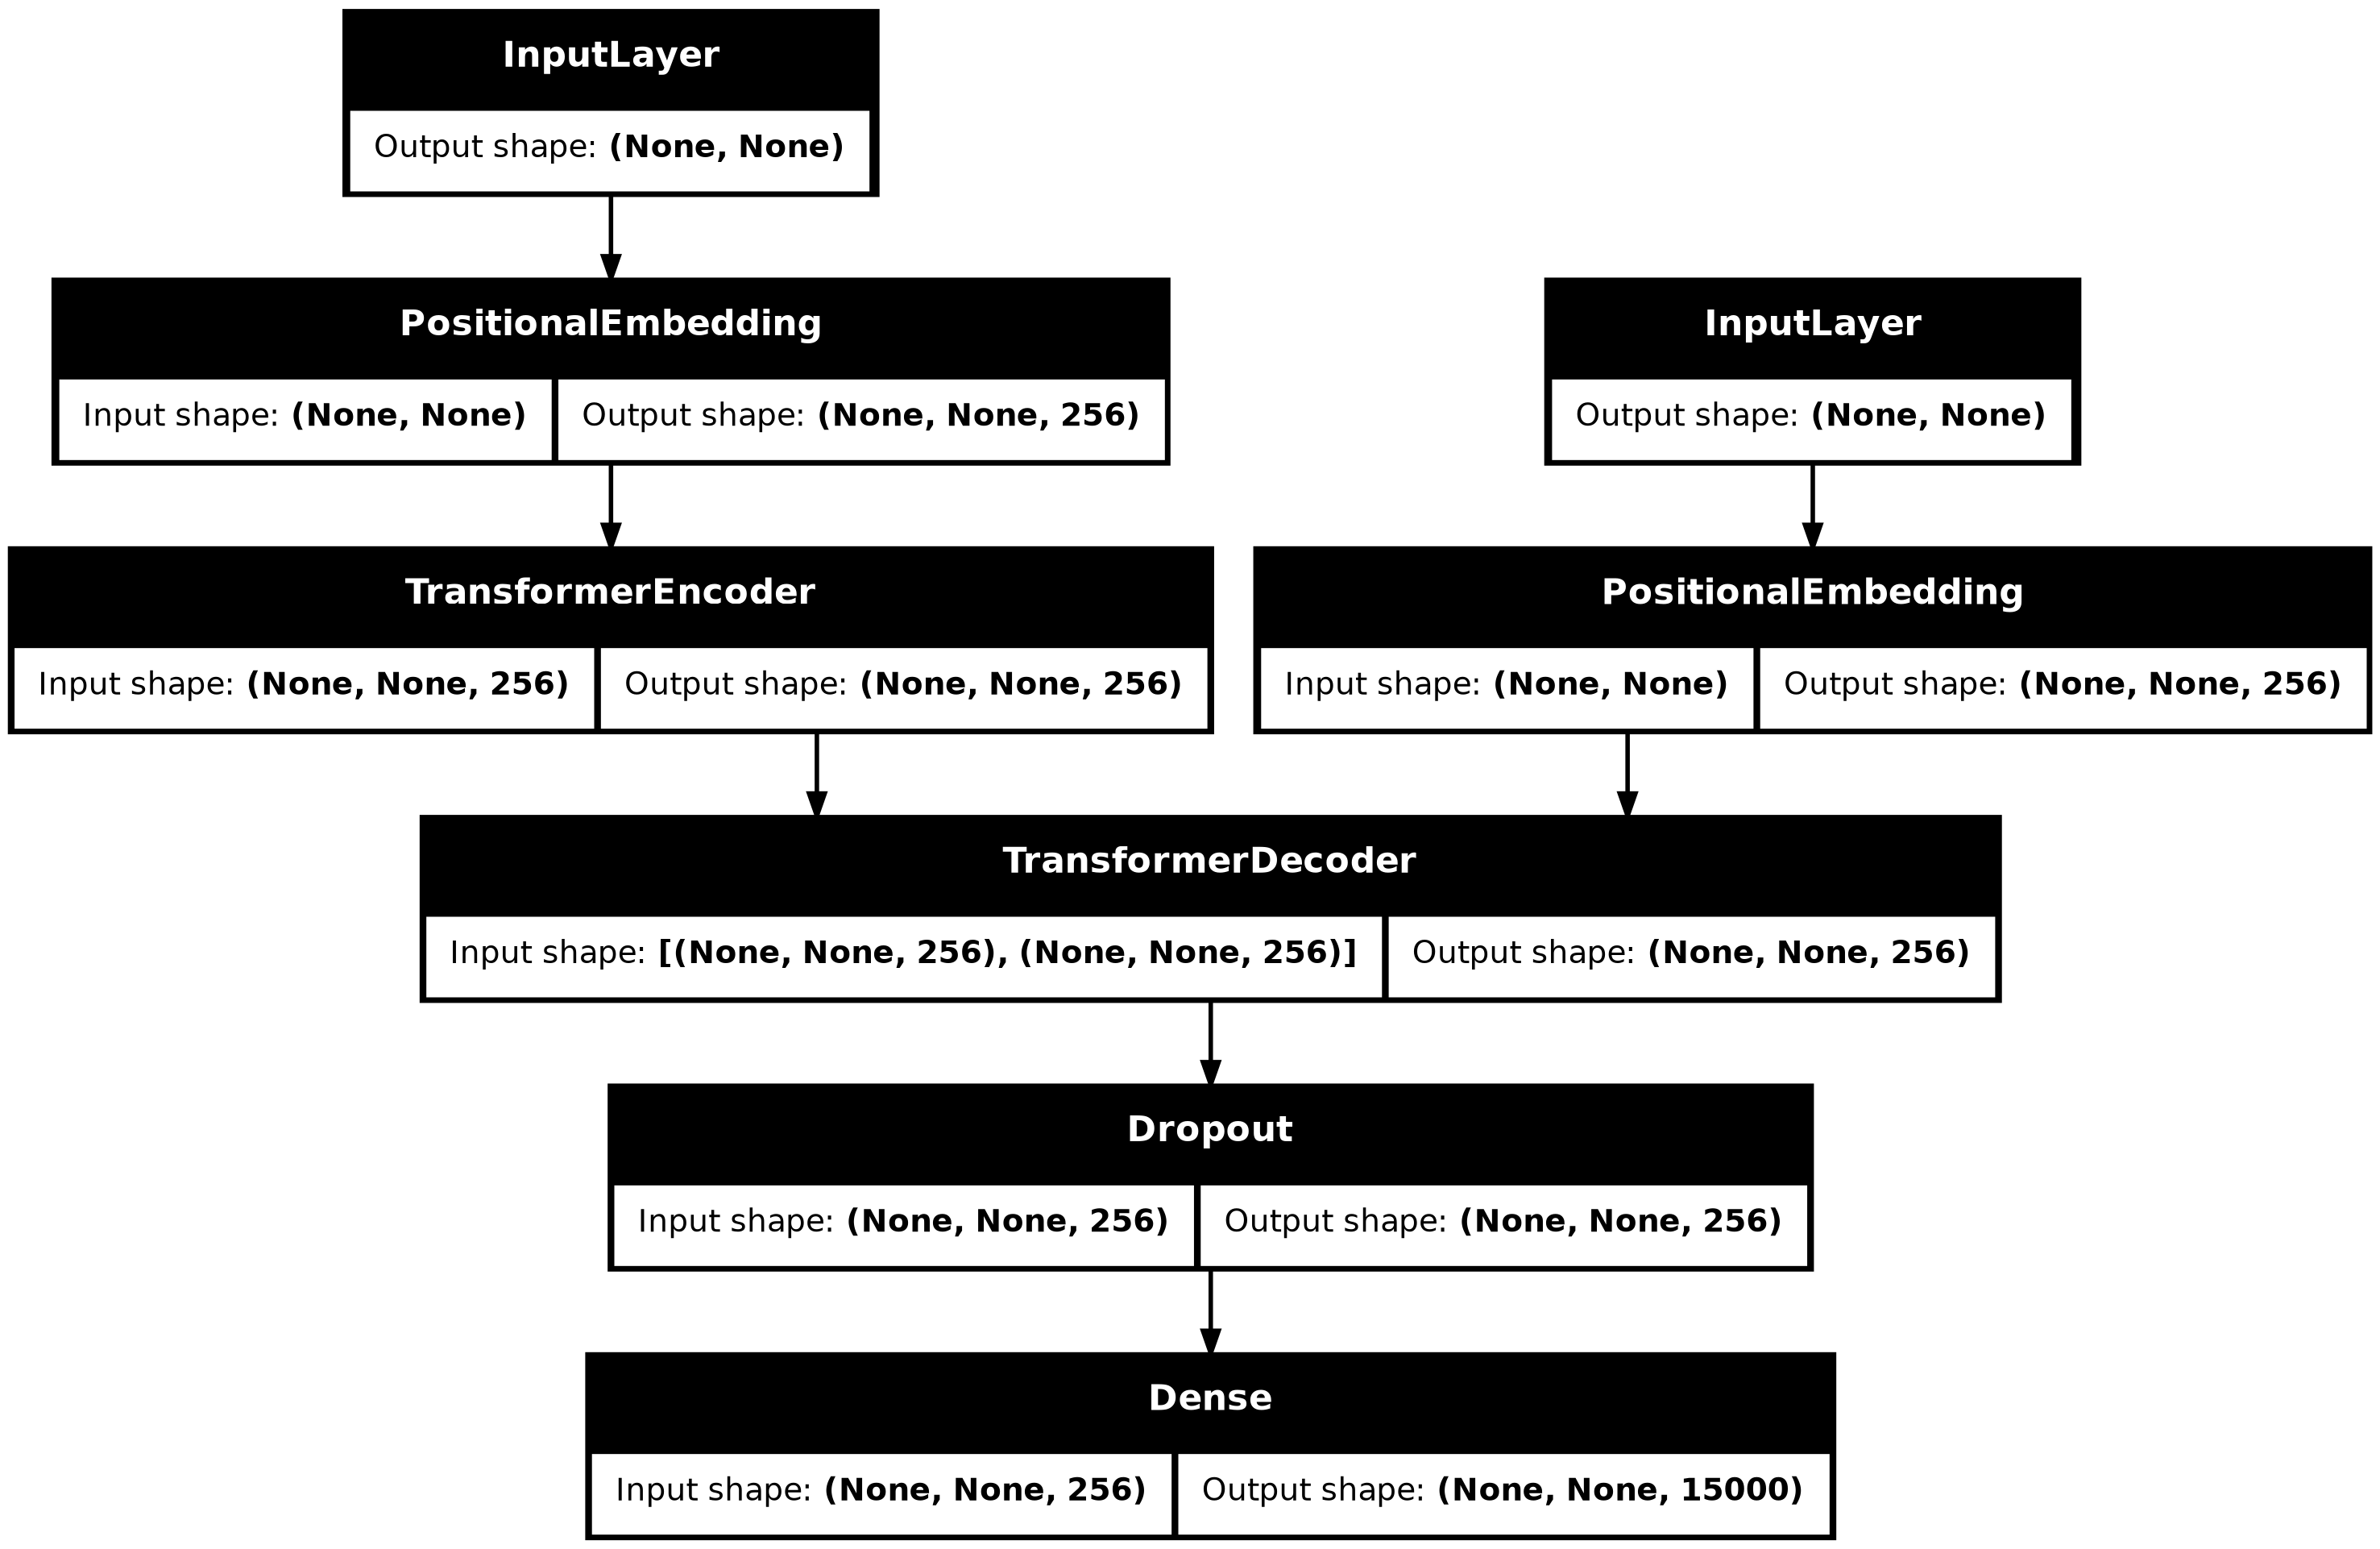

In [60]:
keras.utils.plot_model(transformer, to_file = "translation_transforner.png", show_shapes = True)

In [61]:
transformer.summary()

Model: "functional_21"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ english             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ spanish             │ (None, None)      │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │  3,841,024 │ english[0][0]     │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positional_embeddi… │ (None, None, 256) │  3,841,024 │ spanish[0][0]     │
│ (PositionalEmbeddi… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_encode… │ (None, None, 256) │  2,629,632 │ positional_embed… │
│ (TransformerEncode… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ transformer_decode… │ (None, None, 256) │  4,207,872 │ positional_embed… │
│ (TransformerDecode… │                   │            │ transformer_enco… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_28          │ (None, None, 256) │          0 │ transformer_deco… │
│ (Dropout)           │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_38 (Dense)    │ (None, None,      │  3,855,000 │ dropout_28[0][0]  │
│                     │ 15000)            │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 18,374,552 (70.09 MB)

 Trainable params: 18,374,552 (70.09 MB)

 Non-trainable params: 0 (0.00 B)

In [62]:
transformer.compile(
    optimizer="rmsprop",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"])

history = transformer.fit(train_ds, epochs=15, validation_data=val_ds)

Epoch 1/15


I0000 00:00:1731762559.494551  125916 service.cc:146] XLA service 0x7fe334042600 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1731762559.494584  125916 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2024-11-16 13:09:19.652836: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
W0000 00:00:1731762559.756568  125916 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-11-16 13:09:19.979769: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at scatter_nd_op.cc:131 : INVALID_ARGUMENT: indices[4] = [4] does not index into shape [4]
2024-11-16 13:09:19.980639: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at scatter_nd_op.cc:131 : INVALID_A

1595/2603 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.7609 - loss: 1.9770

W0000 00:00:1731762591.330230  125913 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-11-16 13:09:51.475791: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at scatter_nd_op.cc:131 : INVALID_ARGUMENT: indices[4] = [4] does not index into shape [4]
2024-11-16 13:09:51.476173: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at scatter_nd_op.cc:131 : INVALID_ARGUMENT: indices[4] = [4] does not index into shape [4]
2024-11-16 13:09:51.477041: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at scatter_nd_op.cc:131 : INVALID_ARGUMENT: indices[4] = [4] does not index into shape [4]
2024-11-16 13:09:51.628438: W tensorflow/core/framework/op_kernel.cc:1840] OP_REQUIRES failed at scatter_nd_op.cc:131 : INVALID_ARGUMENT: indices[4] = [4] does not index into shape [4]
2024-11-16 13:09:51.628812: W tensorflow/core/framework/op_kernel.cc:1

2603/2603 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step - accuracy: 0.7674 - loss: 1.8311

W0000 00:00:1731762614.695704  125912 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
W0000 00:00:1731762616.610591  125913 assert_op.cc:38] Ignoring Assert operator compile_loss/sparse_categorical_crossentropy/SparseSoftmaxCrossEntropyWithLogits/assert_equal_1/Assert/Assert
2024-11-16 13:10:17.599858: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_21', 16 bytes spill stores, 16 bytes spill loads

2024-11-16 13:10:17.630097: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_24', 36 bytes spill stores, 36 bytes spill loads

2024-11-16 13:10:17.808284: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory 

2603/2603 ━━━━━━━━━━━━━━━━━━━━ 66s 19ms/step - accuracy: 0.7675 - loss: 1.8310 - val_accuracy: 0.8033 - val_loss: 1.3086
Epoch 2/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.8001 - loss: 1.3655 - val_accuracy: 0.8225 - val_loss: 1.1735
Epoch 3/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.8189 - loss: 1.2325 - val_accuracy: 0.8356 - val_loss: 1.0930
Epoch 4/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.8321 - loss: 1.1409 - val_accuracy: 0.8390 - val_loss: 1.0869
Epoch 5/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.8347 - loss: 1.1322 - val_accuracy: 0.8402 - val_loss: 1.0727
Epoch 6/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.8377 - loss: 1.1196 - val_accuracy: 0.8451 - val_loss: 1.0426
Epoch 7/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 30s 11ms/step - accuracy: 0.8432 - loss: 1.0837 - val_accuracy: 0.8503 - val_loss: 1.0162
Epoch 8/15
2603/2603 ━━━━━━━━━━━━━━━━━━━━ 30s 12ms/step - accuracy: 0.8482 - loss: 1.05

In [63]:
transformer.save("translation_transformer.keras")

In [66]:
spa_vocab = target_vectorization.get_vocabulary()
spa_index_lookup = dict(zip(range(len(spa_vocab)), spa_vocab))
max_decoded_sentence_length = 20

def decode_sequence(input_sentence):
    tokenized_input_sentence = source_vectorization([input_sentence])
    decoded_sentence = "[start]"  # Seed token

    for i in range(max_decoded_sentence_length):
        # Tokenize the current decoded sentence
        tokenized_target_sentence = target_vectorization([decoded_sentence])[:, :-1]

        # Predict next token
        next_token_predictions = transformer.predict(
            {"english":tokenized_input_sentence, "spanish":tokenized_target_sentence}, \
            verbose = 0
        )

        # selects the index of the token with the highest probability 
        # from the prediction.
        # shape = (next_batch_size, max_decoded_sentence_length, target_vocab_size)

        # 0: Refers to the first (and only) batch item. Since the batch size is 1, this is always 0
        # i: Refers to the position of the token in the decoded sequence 
        # :: Refers to all values for the target vocabulary at this specific token position. 
        # This means all possible token predictions (i.e., the probability distribution over the entire vocabulary) for the i-th position
        
        sampled_token_index = np.argmax(next_token_predictions[0, i, :])

        # Retrieve the token
        sampled_token = spa_index_lookup[sampled_token_index]  

        # Update the decoded sentence
        decoded_sentence += " " + sampled_token

        # Termination condition   
        if sampled_token == "[end]":     
            break

    return decoded_sentence

test_eng_texts = [pair[0] for pair in test_pairs] 
for _ in range(20):
    input_sentence = random.choice(test_eng_texts)
    print("-")
    print(input_sentence)
    print(decode_sequence(input_sentence))

-
Don't stay out too late.


2024-11-16 13:32:32.347211: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 204 bytes spill stores, 204 bytes spill loads

2024-11-16 13:32:32.963449: I external/local_xla/xla/stream_executor/cuda/cuda_asm_compiler.cc:393] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_10', 40 bytes spill stores, 72 bytes spill loads



[start] no [UNK] demasiado tarde[end]                
-
It's on fire.
[start]                    
-
Let's walk a little faster.
[start] un poco más rápido[end]                
-
What are you knitting?
[start] lo que estás [UNK]                
-
She has a big family.
[start] tiene una familia[end]                 
-
When did he go?
[start] lo que [UNK]                 
-
Tom didn't have the courage to disobey Mary.
[start] no haber [UNK] el [UNK]               
-
He was awarded a special prize.
[start] que [UNK] un [UNK]                
-
Tom was worried about his grades?
[start] a tom de sus [UNK]               
-
His face turned pale on hearing the news.
[start]                    
-
Children like gummy bears.
[start] los hombres [UNK]                 
-
My sister is twenty-one years old and a college student.
[start] a mi hermana como un [UNK] y el [UNK]           
-
An MP3 file is an audio file.
[start] un [UNK] es un [UNK]               
-
They ate marshmallows.
[start] se comió l